# AULA 4 - CONSTRUINDO BACKTEST
15/04/2025

### Importando bibliotecas e lendo a base de dados:

In [54]:
import pandas as pd  
import numpy as np  
import datetime as dt  
import quantstats as qs  # Biblioteca quantstats, responsável por gerar gráficos de desempenho da carteira
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

closing_price = pd.read_excel('FECHAMENTO2_aula.xlsx')

In [55]:
closing_price['Data'] = pd.to_datetime(closing_price['Data'])
closing_price = closing_price.set_index('Data')

### Adicionando dados do INEG (Índice de negociabilidade)

In [57]:
dados_ineg = pd.read_excel('ineg_dadlimpo.xlsx')
dados_ineg['Data'] = pd.to_datetime(dados_ineg['Data'])
dados_ineg = dados_ineg.set_index('Data')

### DEFININDO PARÂMETROS:

In [59]:
initial_date = pd.Timestamp(dt.date(2017,2,2)) # Data inicial
final_date = closing_price.index[-1] #No projeto deve-se definir uma data fixa final, para evitar possíveis erros
lookback_momentum = 1 #Lookback em meses, cada fator terá o seu próprio
rebal_time = 1 #Tempo de rebalanceamento da carteira (único para todos os fatores)
lookback_ibx = 3

In [60]:
dados_ineg
# dados_ineg = dados_ineg.drop(columns=['Unnamed: 0', 'Unnamed: 2'])
dados_ineg = dados_ineg.dropna(axis=1, how='all')

cutoff_date = initial_date  
dados_ineg = dados_ineg[dados_ineg.index >= cutoff_date]

dados_ineg

,Unnamed: 0,Unnamed: 2,TTEN3,ABCB4,EALT3,EALT4,AERI3,AESB3,AFLT3,AGXY3,...,MWET3,MWET4,WHRL3,WHRL4,PORT3,WIZC3,WLMM3,WLMM4,YDUQ3,ZAMP3
Data,,,,,,,,,,,,,,,,,,,,,
2017-02-02,8113,7.167424,NaN,0.087628,NaN,0.000138,NaN,0.251772,0.000040,NaN,...,NaN,0.000055,0.000283,0.000850,0.004587,0.045055,0.000015,0.000674,0.484579,NaN
2017-02-03,8114,7.121361,NaN,0.087669,NaN,0.000138,NaN,0.253363,0.000040,NaN,...,NaN,0.000055,0.000274,0.000828,0.004730,0.047198,0.000015,0.000721,0.493660,NaN
2017-02-06,8115,7.083069,NaN,0.088576,NaN,0.000138,NaN,0.254713,0.000041,NaN,...,NaN,0.000056,0.000272,0.000813,0.004720,0.047503,0.000016,0.000742,0.514126,NaN
2017-02-07,8116,7.009501,NaN,0.089445,NaN,0.000138,NaN,0.253057,0.000041,NaN,...,NaN,0.000056,0.000275,0.000808,0.005129,0.048954,0.000016,0.000745,0.522178,NaN
2017-02-08,8117,7.000121,NaN,0.088526,NaN,0.000138,NaN,0.250803,0.000041,NaN,...,NaN,0.000057,0.000271,0.000713,0.005113,0.050476,0.000015,0.000741,0.528527,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04,10135,5.090151,0.106824,0.101551,0.000454,0.003506,0.023699,0.240504,0.000034,0.004394,...,NaN,0.000024,0.000223,0.000604,0.153898,0.025286,0.000024,0.000187,0.388187,0.022115
2024-11-05,10136,5.071803,0.107279,0.101955,0.000454,0.003517,0.023946,0.236907,0.000034,0.004363,...,NaN,0.000036,0.000226,0.000600,0.155749,0.025065,0.000024,0.000184,0.388525,0.021673
2024-11-06,10137,5.058862,0.108286,0.100790,0.000453,0.003506,0.024127,0.234809,0.000034,0.004284,...,NaN,0.000042,0.000226,0.000601,0.157129,0.025105,0.000023,0.000184,0.384864,0.021664


### LOOP PRINCIPAL:

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-03-06   2017-03-06
End Period                 2018-11-30   2018-11-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -1.07%       16.9%
CAGR﹪                     -0.43%       6.4%

Sharpe                     0.06         0.52
Prob. Sharpe Ratio         52.98%       74.52%
Smart Sharpe               0.06         0.51
Sortino                    0.08         0.73
Smart Sortino              0.08         0.72
Sortino/√2                 0.05         0.51
Smart Sortino/√2           0.05         0.51
Omega                      1.09         1.09

Max Drawdown               -29.02%      -25.39%
Longest DD Days            438          278
Volatility (ann.)          18.62%       23.83%
R^2                        0.6          0.6
Information Ratio          0.05         0.05
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-02-26,2018-09-13,2018-11-30,278,-25.389698,-25.207892
2,2017-03-08,2017-05-18,2017-08-16,162,-14.073427,-12.319087
3,2017-10-11,2017-11-14,2018-01-19,101,-10.499024,-10.122473
4,2017-09-20,2017-09-25,2017-09-29,10,-5.420071,-4.739245
5,2018-02-07,2018-02-09,2018-02-15,9,-4.142035,-2.021951


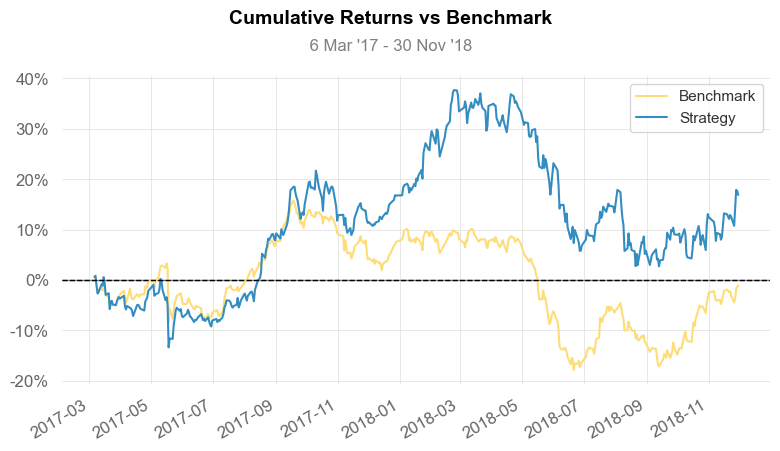

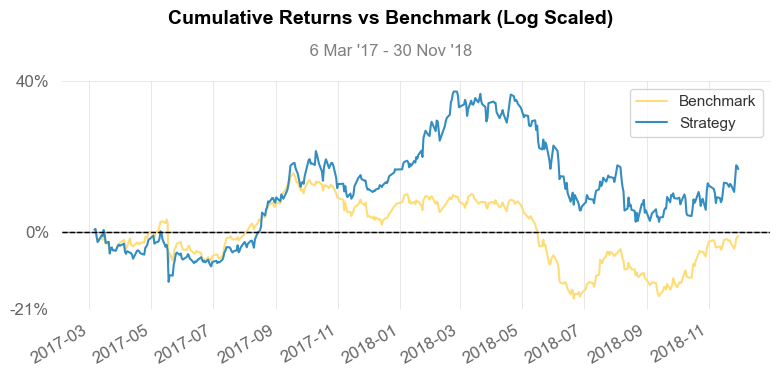

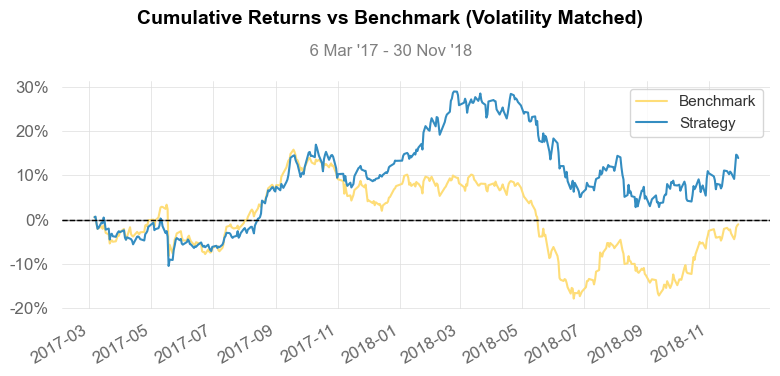

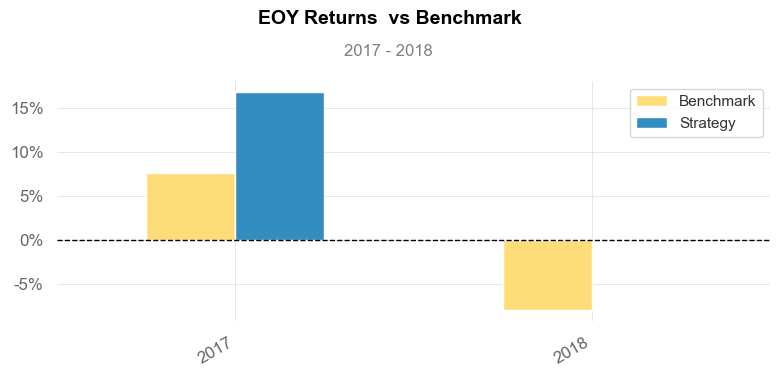

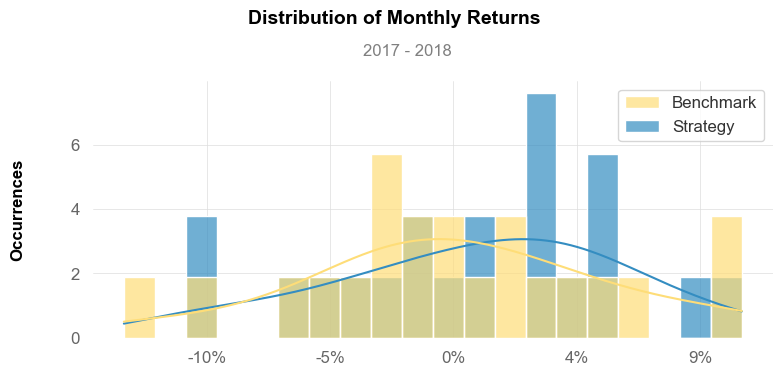

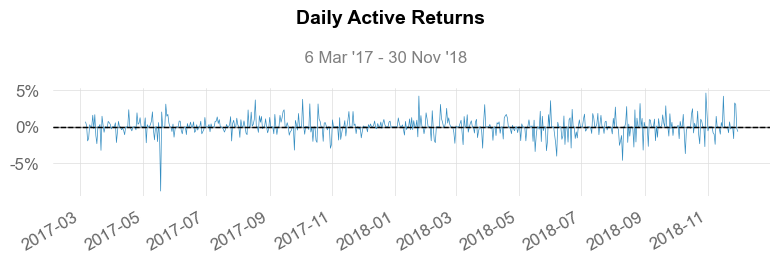

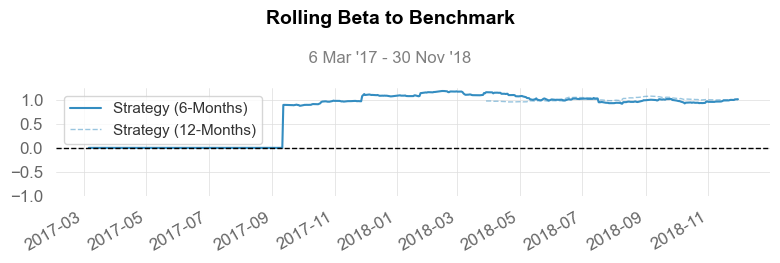

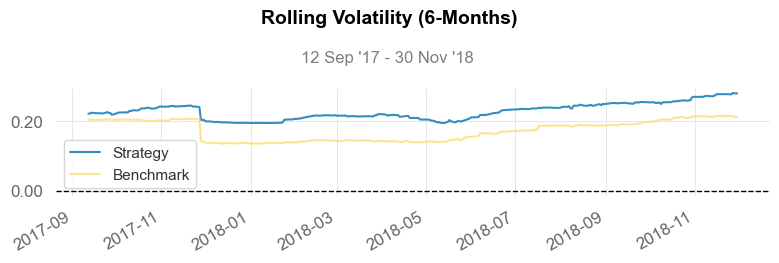

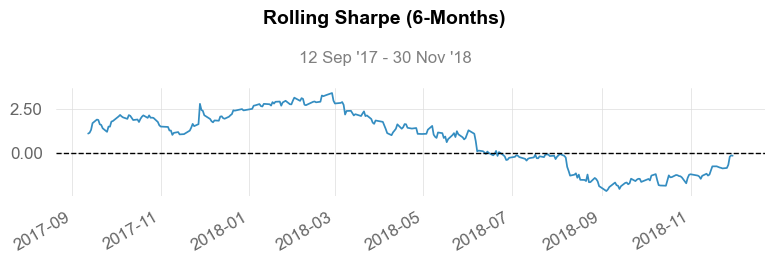

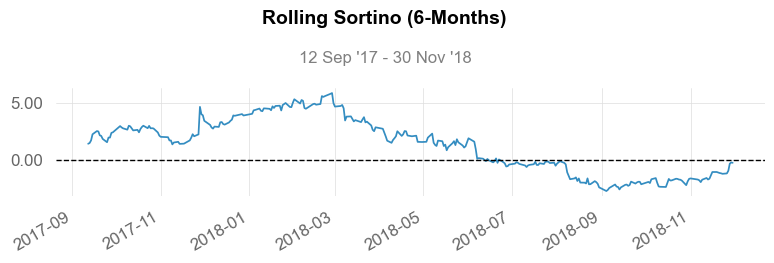

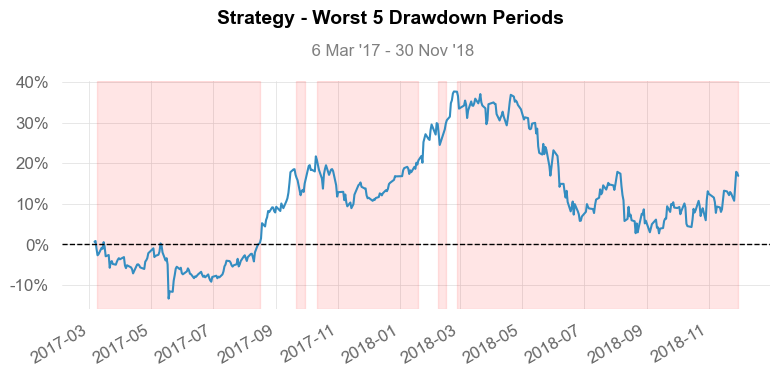

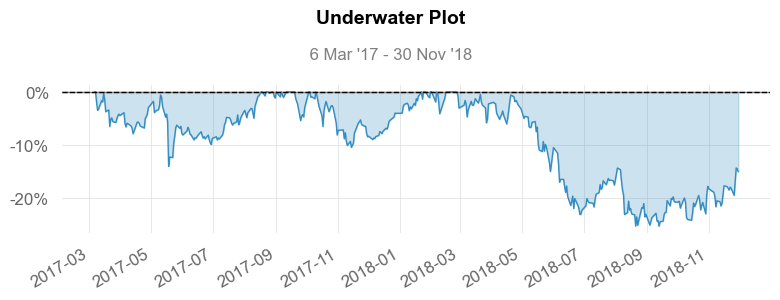

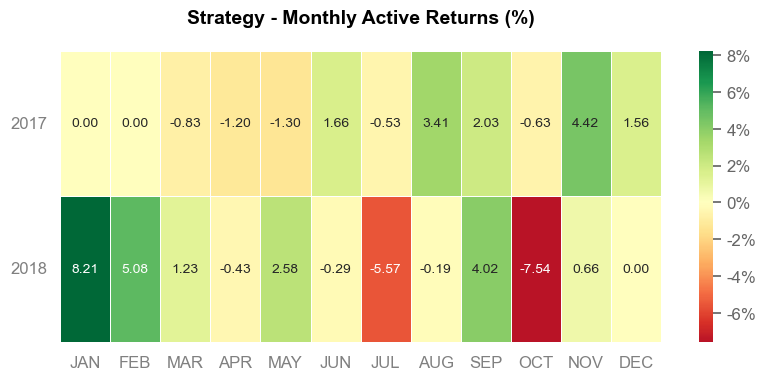

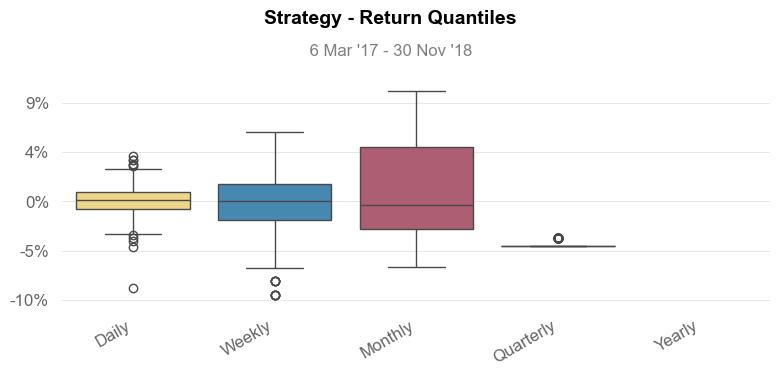

In [62]:
#Criando nova base de dados para armazenar retornos
returns = pd.DataFrame()

#Inicio do loop
while True:
    #Calculando a proxima data de rebalanceamento
    rebal = initial_date + pd.DateOffset(months=rebal_time) 
    # Verificar se a data de rebalanceamento está dentro do intervalo de dados
    if rebal <= final_date:

        # Processamento de ineg
        ineg_date_analysis = initial_date - pd.DateOffset(months=lookback_ibx)
        ineg = dados_ineg[(dados_ineg.index < initial_date) & (dados_ineg.index >= ineg_date_analysis)]
        ineg = ineg.ffill().bfill()
        if not ineg.empty:
            ineg = ineg.iloc[-1]
        else:
            initial_date += pd.DateOffset(months=rebal_time)
            continue  # Pula esse ciclo e vai para o próximo        
        ineg = ineg.reset_index()
        ineg.columns = ['ticker', 'neg'] if 'neg' not in ineg.columns else ineg.columns
        ibx_tickers = ineg.sort_values(by='neg', ascending=False).head(100)['ticker'].tolist()  # Top 100 tickers by liquidity


        
        # Define o intervalo para analisar o desempenho passado das ações
        momentum_date_analysis = initial_date - pd.DateOffset(months=lookback_momentum)
        # Filtra os preços dentro do intervalo desejado
        momentum = closing_price[(closing_price.index < initial_date) & (closing_price.index > momentum_date_analysis)]
        #cálculo do momentum:
        momentum = momentum.pct_change().add(1).cumprod().add(-1)

        # Pega apenas a última linha dos retornos acumulados (mais recente)
        momentum = momentum.iloc[-1]

        # Converte para DataFrame e renomeia as colunas
        momentum = momentum.reset_index()
        momentum.columns = ['ticker', 'value'] #Ticker = nome da ação e value = valor da ação
        momentum = momentum[momentum['ticker'].isin(ibx_tickers)]  #Verifica se a ação está entre as top 100 mais negociadas na bolsa 


        # Ordena da maior performance para a menor
        momentum = momentum.sort_values(by='value', ascending=False).reset_index(drop=True)

        # Seleciona os 40% melhores (vencedores), selecionados para a carteira
        book_winners = momentum.ticker[:int(len(momentum) * 0.4)]

        # O restante serão os perdedores
        book_losers = [l for l in list(momentum['ticker']) if l not in list(book_winners)] #for das ações, retirando aquelas que não estão nos vecedores


#  ----------------------------------------------   BACKTEST UNIVERSE -----------------------------------------------------------------------------
# No backtest do universo, são consideranda todas as ações da bolsa para servir como benchmark da performace

        # Basicamente refazendo o processo das linhas anteriores:
        # Filtra os dados de todos os ativos no período atual de rebalanceamento
        backtest_universe = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_universe = backtest_universe.pct_change().replace(np.nan, 0)  # Calcula os retornos, outra forma de calcular

        # Cria uma coluna com a média dos retornos do universo 
        backtest_universe['Retorno'] = backtest_universe.mean(axis=1)
        backtest_universe_ret = backtest_universe['Retorno'][1:]  # Remove o primeiro NaN

#  ----------------------------------------------   BACKTEST LOOSERS -----------------------------------------------------------------------------
        
        backtest_losers = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_losers = backtest_losers[book_losers].pct_change().replace(np.nan, 0)
        backtest_losers['Retorno'] = backtest_losers.mean(axis=1)
        backtest_losers_ret = backtest_losers['Retorno'][1:] 
        
#  ----------------------------------------------   BACKTEST WINNERS -----------------------------------------------------------------------------

        backtest_winners = closing_price[(closing_price.index >= initial_date) & (closing_price.index < rebal)]
        backtest_winners = backtest_winners[book_winners].pct_change().replace(np.nan, 0)
        backtest_winners['Retorno'] = backtest_winners.mean(axis=1)
        backtest_winners_ret = backtest_winners['Retorno'][1:]

        # Cria um DataFrame com os retornos de cada grupo
        retorno_rebal = pd.DataFrame({
            'Winners': backtest_winners_ret,
            'Universo': backtest_universe_ret,
            'Losers': backtest_losers_ret
        })

        # Junta os retornos dessa rodada com os anteriores
        returns = pd.concat([returns, retorno_rebal], ignore_index=False)

        # Avança a data inicial para o próximo rebalanceamento
        initial_date = initial_date + pd.DateOffset(months=rebal_time)
    else:
        break  # Sai do loop se não houver mais dados disponíveis

# Converte os retornos simples em retornos acumulados (crescimento do investimento)
returns = returns.add(1).cumprod()

# Gera um relatório completo comparando a performance dos "Winners" com o "Universo"
qs.reports.full(returns['Winners'], returns['Universo'])